In [1]:
import time
from datetime import datetime, timedelta
import sys
import tensorflow as tf
import numpy as np
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import matplotlib.pyplot as plt

In [2]:
#start = time.time()
#!unzip "/content/drive/MyDrive/human_pose_estimation/datasets/coco/tfrecords.zip"
#total_time = time.time() - start
#print("Total time: {}".format(str(timedelta(seconds=total_time))))

In [3]:
sys.path.insert(0, "/content/drive/MyDrive/human_pose_estimation/")

In [4]:
from data_generator import DataGenerator

In [5]:
from hourglass_blocks import create_hourglass_network, bottleneck_block
from gen_tfrecords import parse_tfrecord_fn, gen_examples_from_tfrecord

vis: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0.]
xcoords: [  83.   98.   68.  142.   68.  188.   48.  240.   46.  278.   77.  171.
  100. -167. -167. -167. -167.]
ycoords: [  82.   61.   73.   65.   91.  175.  180.  332.  358.  455.  285.  441.
  446. -162. -162. -162. -162.]
ann_id: 453991
height: 465
image_id: 36
image_path: b'datasets/train2017/000000000036.jpg'
width: 310
Image shape: (465, 310, 3)


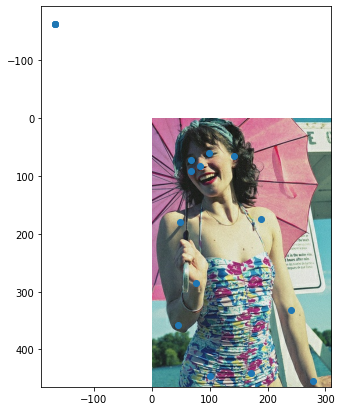

In [6]:
gen_examples_from_tfrecord("tfrecords/train/file_train_00-1024.tfrec", 1)

In [7]:
#constants
SIZE = 256
HMAP_SIZE = 64
BATCH_SIZE = 16
GAUSSIAN_KERNEL = 7 # adjust to size of pic EX: 128 => 51 ratio of 0.4


TRAIN_EXAMPLES = 149813
VALID_EXAMPLES = 6352
STEPS_PER_EPOCH = TRAIN_EXAMPLES // BATCH_SIZE + 1
VALIDATION_STEPS = VALID_EXAMPLES // BATCH_SIZE + 1
NUM_EPOCHS = 1000

filters_const = 256
number_keypoints = 17
num_stacks = 4

train_path = "tfrecords/train"
valid_path = "tfrecords/valid"
train_filenames = tf.io.gfile.glob(f"{train_path}/*.tfrec")
valid_filenames = tf.io.gfile.glob(f"{valid_path}/*.tfrec")

In [8]:
train = DataGenerator(train_filenames, TRAIN_EXAMPLES, (256, 256, 3),  (64, 64, number_keypoints), 17, 5, 16, True)

In [9]:
ds_train = train.generateDataset()

In [1]:
def np_heatmap(x, y):
  width = HMAP_SIZE 
  height = HMAP_SIZE
  assert len(x) == len(y) and len(x)== number_keypoints
  depth = len(x)
  #generate heat map
  h_map = np.zeros((width, height, depth))
  for i in range(depth):
    x_index = round(x[i]) #width
    y_index = round(y[i]) #height
    if (0 < x_index < width) and (0 < y_index < height): 
      h_map[y_index][x_index][i] = 1.0 #entry at keypoint = 1
      h_map[:,:,i] = cv2.GaussianBlur(h_map[:,:,i],(GAUSSIAN_KERNEL, GAUSSIAN_KERNEL), 0)#blur
      h_map[:,:,i] = h_map[:,:,i] / h_map[:,:,i].max()#normalize
  return h_map.astype(np.float32)
def tf_heatmap(input1 , input2):
  return tf.numpy_function(np_heatmap, [input1, input2], tf.float32)

In [ ]:
def np_augment(img, xcoords, ycoords):

  #lsit of tuples [(x1, y1), ...]
  kps = [] 
  idx = [] #to store index of valid kps
  for i in range(len(xcoords)):
    x = xcoords[i]
    y = ycoords[i]
    if 0 < x < img.shape[1] and 0 < y < img.shape[0]:
      kps.append(Keypoint(x = x, y = y))
      idx.append(i)

  kpsoi = KeypointsOnImage(kps, shape = img.shape)

  #augment
  seed = np.random.randint(2**32-1)
  ia.seed(seed)
  seq = iaa.Sequential([
    iaa.Affine(scale = (0.75, 1.25), rotate = (-30, 30)),
    iaa.Fliplr(0.5),
    ], random_order = False) #cause rotate/scale then flip can be problematic
  aug_img, aug_kps = seq(image = img, keypoints = kpsoi)

  #turn aug_kps back to x, y lists
  arr = aug_kps.to_xy_array()
  
  temp_xcoords = arr[:, 0]
  temp_ycoords = arr[:, 1]
  aug_xcoords = np.zeros(shape = (number_keypoints), dtype = np.float32)
  aug_ycoords = np.zeros(shape = (number_keypoints), dtype = np.float32)

  for i, x, y in zip(idx, temp_xcoords, temp_ycoords):
    aug_xcoords[i] = x
    aug_ycoords[i] = y;
  return aug_img, aug_xcoords, aug_ycoords
def tf_augment(img, xcoords, ycoords):
  return tf.numpy_function(np_augment, [img, xcoords, ycoords], (tf.float32, tf.float32, tf.float32))

In [8]:
def prepare_sample(example):
  ## Getting all the necessary data
  img = example['image']
  img_shape = img.get_shape()
  height = example['height']
  width = example['width']
  xcoords = example['xcoords'] 
  ycoords = example['ycoords']

  # img, x, y should be in image's dimensions
  aug_img, aug_xcoords, aug_ycoords = tf_augment(img, xcoords, ycoords)
  aug_img.set_shape(img_shape)
  #recal x,y into heatmaps space
  h_ratio = HMAP_SIZE / height
  w_ratio = HMAP_SIZE / width 
  aug_xcoords = aug_xcoords * tf.cast(w_ratio, tf.float32)
  aug_ycoords = aug_ycoords * tf.cast(h_ratio, tf.float32)

  #heatmap
  heatmap = tf_heatmap(aug_xcoords, aug_ycoords)

  #img to (256, 256)
  aug_img = tf.image.resize(aug_img, (SIZE, SIZE))

  return  aug_img, heatmap

In [ ]:
#training pipeline
ds_train = tf.data.TFRecordDataset(train_filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) #create dataset
ds_train = ds_train.repeat(NUM_EPOCHS)
ds_train = ds_train.shuffle(BATCH_SIZE * 100) #for true randomness, buffer is set to the num of examples in training set
#ds_train = ds_train.cache() #cache before shuffeling for better performance
ds_train = ds_train.map(parse_tfrecord_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(prepare_sample, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE) #batch after shuffling to get unique batches at each epoch
#ds_train = ds_train.map(tf_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)#good practice to end the pipeline by prefetching

#testing pipeline
ds_valid = tf.data.TFRecordDataset(valid_filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) #create dataset
ds_valid = ds_valid.repeat(NUM_EPOCHS)
#ds_valid = ds_valid.cache()
ds_valid = ds_valid.map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.map(prepare_sample, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_valid = ds_valid.batch(BATCH_SIZE)
ds_valid = ds_valid.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
it = iter(ds_train)

In [11]:
images_batch, heatmaps_batch = next(it)

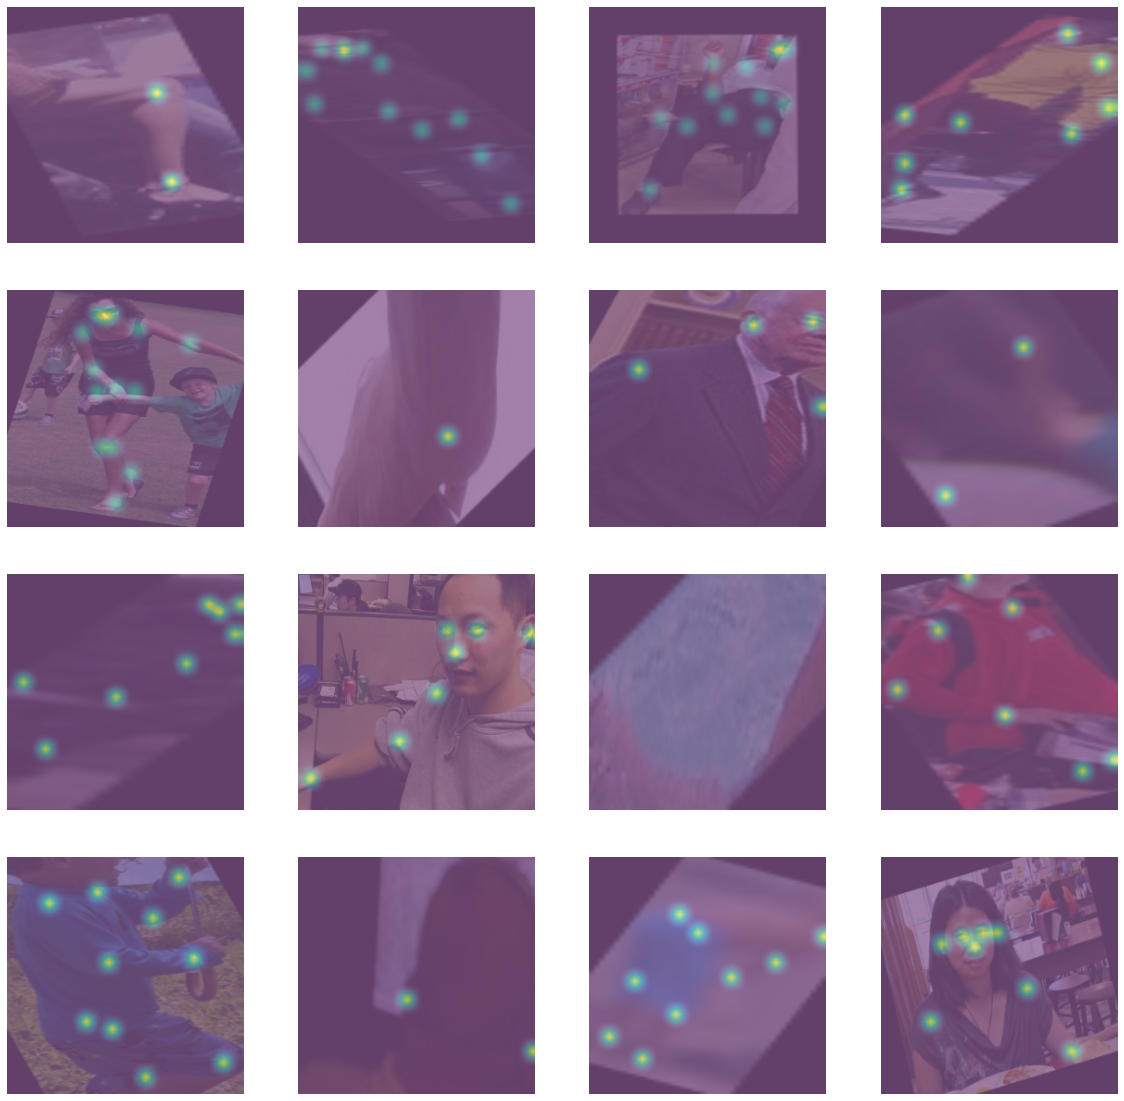

In [12]:
#ground truth
plt.figure(figsize=(20,20))
for i in range(BATCH_SIZE):
    ax = plt.subplot(BATCH_SIZE/4, BATCH_SIZE/4, i + 1)
    plt.imshow(images_batch[i], cmap = 'gray', alpha = 0.5)
    h = tf.image.resize(heatmaps_batch[i], (SIZE, SIZE))
    plt.imshow(tf.reduce_sum(h, axis = -1), alpha = 0.5)
    plt.axis("off")

In [ ]:
model = create_hourglass_network(number_keypoints, 4, 256, (256, 256, 3),  bottleneck_block, 'sigmoid')
#model.summary()

Total params: 13,773,484

Trainable params: 13,707,820

Non-trainable params: 65,664

4 stacks

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError(),)

In [ ]:
#learning rate call back
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience= 20, verbose = 1, min_lr=1e-6)

#early stoppping call back
early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 50, verbose=1, restore_best_weights = True)

# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))
call_backs = [
    reduce_lr,
    early_stop,
    #PrintLR()
]

In [ ]:
start = time.time()
H = model.fit(
    ds_train, 
    epochs = 50,#1000
    callbacks = call_backs,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = ds_valid,
    validation_steps = VALIDATION_STEPS
)
total_time = time.time() - start
print("Total time to train: {}".format(str(timedelta(seconds=total_time))))

Epoch 1/50
9364/9364 [==============================] - 3945s 418ms/step - loss: 0.0089 - 0_head_loss_conv_2_1x1_parts_loss: 0.0026 - 1_head_loss_conv_2_1x1_parts_loss: 0.0023 - 2_head_loss_conv_2_1x1_parts_loss: 0.0020 - 3_head_loss_conv_2_1x1_parts_loss: 0.0019 - val_loss: 0.0033 - val_0_head_loss_conv_2_1x1_parts_loss: 8.2596e-04 - val_1_head_loss_conv_2_1x1_parts_loss: 8.2649e-04 - val_2_head_loss_conv_2_1x1_parts_loss: 8.1687e-04 - val_3_head_loss_conv_2_1x1_parts_loss: 8.0823e-04 - lr: 0.0010
Epoch 2/50
5749/9364 [=================>............] - ETA: 24:32 - loss: 0.0033 - 0_head_loss_conv_2_1x1_parts_loss: 8.2695e-04 - 1_head_loss_conv_2_1x1_parts_loss: 8.1742e-04 - 2_head_loss_conv_2_1x1_parts_loss: 8.1160e-04 - 3_head_loss_conv_2_1x1_parts_loss: 7.9673e-04